# Starting out

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Kool/Ülikool/'3. aasta'/Lõputöö/data.zip .
!unzip -q data.zip
!rm data.zip

!cp /content/drive/MyDrive/Kool/Ülikool/'3. aasta'/Lõputöö/test_val.zip .
!unzip -q test_val.zip
!rm test_val.zip

In [ ]:
!rm -rf line-chart-captioning/
#clone repo
!git clone https://github.com/snemvalts/line-chart-captioning
#clean out data folder and move extracted raw data to captioning
!rm -rf line-chart-captioning/data/*
!mv data/** line-chart-captioning/data/
!mv test_val/validation1 line-chart-captioning/data/figureqa/

Cloning into 'line-chart-captioning'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 129 (delta 40), reused 101 (delta 22), pack-reused 0
Receiving objects: 100% (129/129), 22.30 KiB | 4.46 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [ ]:
import json

# Smoothest and roughest seem to always appear. Same for MIN_AUC and MAX_AUC
question_types = ["GREATER", "LESS", "INTERSECT"]
synthetic_json = {
  "questions": question_types
}

with open('line-chart-captioning/synthetic.json', 'w') as f:
  json.dump(synthetic_json, f)

In [ ]:
!ls line-chart-captioning/data/figureqa

README.md  sample_train1  train1  validation1


In [ ]:
!cd line-chart-captioning && \
python3 src/synthetic/preprocess-question-types.py \
--synthetic-config synthetic.json \
data/figureqa/train1

parsing QA...
parsing annotations...
processing plots...
copying images...
writing csv...


In [ ]:
!cd line-chart-captioning && \
python3 src/synthetic/preprocess-question-types.py \
--synthetic-config synthetic.json \
data/figureqa/validation1

parsing QA...
parsing annotations...
processing plots...
copying images...
writing csv...


## creating transforms & dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from skimage import transform


# adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class SyntheticImageDataset(Dataset):
  def __init__(self, csv_file, images_dir, transform=None):
    self.charts_captions = pd.read_csv(csv_file)
    self.images_dir = images_dir
    self.transform = transform

  def __len__(self):
    return len(self.charts_captions)

  def __getitem__(self, idx):
    [image_number, description_blob, all_subjects_blob] = self.charts_captions.iloc[idx]
    image_path = os.path.join(self.images_dir, f'{str(image_number)}.png')
    image = np.array(Image.open(image_path))
    
    sample = {
        'image': image, 
        'original_image': image,
        'description_blob': description_blob,
        'all_subjects_blob': all_subjects_blob   
    }

    if self.transform:
      sample = self.transform(sample)

    return sample

In [ ]:
class ResizeImage(object):
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    resized_image = transform.resize(sample['image'], self.output_size)
    return {**sample, 'image': resized_image}

class StripImageTransparency(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    stripped_transparency_image = sample['image'][:,:,:3]
    return {**sample, 'image': stripped_transparency_image}


class NormalizeImage(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, sample):
    normalized_image = (sample['image'] - self.mean) / self.std
    return {**sample, 'image': normalized_image}


class ImageToTensor(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    image = sample['image'].transpose((2, 0, 1))
    return {**sample, 'image': torch.tensor(image).float()}


class FirstQuestionTypeToOneHotTensor(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    descriptions = json.loads(sample['description_blob'])
    first_description = descriptions[0]
    first_description_type = first_description[0]

    all_description_types = [0]*(len(question_types))

    description_type_index = question_types.index(first_description_type)
    all_description_types[description_type_index] = 1

    return {**sample, 'first_description_type': torch.tensor(all_description_types).float() }


class IncludeSubjectLengths(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    all_subjects_len = len(json.loads(sample['all_subjects_blob']))
    return {**sample, 'subject_lengths': all_subjects_len }

class FirstQuestionSubjectsToOneHotTensor(object):
  def __init__(self, max_len):
    self.max_len = max_len
    pass

  def __call__(self, sample):
    descriptions = json.loads(sample['description_blob'])
    all_subjects = json.loads(sample['all_subjects_blob'])

    first_description = descriptions[0]
    first_description_first_subject = first_description[1]
    first_description_second_subject = first_description[2]

    first_subject_onehot = [0]*self.max_len
    first_description_subject_index = all_subjects.index(first_description_first_subject)
    first_subject_onehot[first_description_subject_index] = 1

    second_subject_onehot = [0]*self.max_len
    second_description_subject_index = all_subjects.index(first_description_second_subject)
    second_subject_onehot[second_description_subject_index] = 1

    return {
        **sample, 
        'first_description_subject_onehot': torch.tensor(first_subject_onehot).long(),
        'first_description_subject_index': first_description_subject_index,
        'second_description_subject_onehot': torch.tensor(second_subject_onehot).long(),
        'second_description_subject_index': second_description_subject_index
    }



In [ ]:
import torch

def get_dataset(images_dir = None, csv_file = None):
  # parallely calculate max caption len and word map to pass it to padcaption
  # cause can't access dataset from transforms before it is defined in compose

  captions_csv = pd.read_csv(csv_file)
  
  max_subjects_len = captions_csv['all_subjects_blob'].apply(lambda blob: len(json.loads(blob))).max()
  

  #TODO: maybe rearrange according to size?
  train_dataset = SyntheticImageDataset(images_dir = images_dir,
                           csv_file = csv_file,
                           transform=transforms.Compose([
                                  ResizeImage((224, 224)),
                                  StripImageTransparency(),
                                  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ImageToTensor(),
                                  FirstQuestionTypeToOneHotTensor(),
                                  FirstQuestionSubjectsToOneHotTensor(max_subjects_len),
                                  IncludeSubjectLengths()
                                 ]))
                                 

  return train_dataset, max_subjects_len


train_dataset, max_subjects_len = get_dataset(images_dir = 'line-chart-captioning/data/processed_synthetic/train1-types/images',
                      csv_file = 'line-chart-captioning/data/processed_synthetic/train1-types/captions.csv')

validation_dataset = SyntheticImageDataset(images_dir = 'line-chart-captioning/data/processed_synthetic/validation1-types/images',
                           csv_file = 'line-chart-captioning/data/processed_synthetic/validation1-types/captions.csv',
                           transform=transforms.Compose([
                                  ResizeImage((224, 224)),
                                  StripImageTransparency(),
                                  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ImageToTensor(),
                                  FirstQuestionTypeToOneHotTensor(),
                                  FirstQuestionSubjectsToOneHotTensor(max_subjects_len),
                                  IncludeSubjectLengths()
                                 ]))

batch_size=1

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)


## encoder and elements model

In [ ]:
import torchvision
from torch import nn

class Encoder(nn.Module):
  def __init__(self, encoder_shape):
    super(Encoder, self).__init__()

    base_resnet = torchvision.models.resnet50(pretrained=True) 
    resnet_without_fc = nn.Sequential(*(list(base_resnet.children())[:-2]))

    # freeze weights of resnet 
    #for parameter in resnet_without_fc.parameters():
    #  parameter.requires_grad = False


    self.resnet = resnet_without_fc
    self.pool = nn.AdaptiveAvgPool3d(encoder_shape)

  
  def forward(self, x):
    x = self.resnet(x)
    x = self.pool(x)
    x = torch.reshape(x, (-1, 2048*3*3))
    return x

class SubjectsModel(nn.Module):
  def __init__(self, encoder_shape, 
               category_count,
               subject_max_len, 
               cut_off=True):
    super(SubjectsModel, self).__init__()

    encoder_dim = 1
    for dim in encoder_shape:
      encoder_dim *= dim

    self.question_type_dense = nn.Linear(category_count, 1024)
    self.other_subject_dense = nn.Linear(subject_max_len, 1024)
    self.encoder_dense = nn.Linear(encoder_dim, 1024)

    hidden_dim = 1024 * 3

    self.hidden1 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden4 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden5 = nn.Linear(hidden_dim, hidden_dim)

    self.output = nn.Linear(hidden_dim, subject_max_len)

    self.relu = nn.ReLU()

    self.cut_off = cut_off
    self.softmax = nn.Softmax()
    self.init_weights()

  def init_weights(self):
    for m in [self.question_type_dense, self.other_subject_dense, self.encoder_dense,
              self.hidden1, self.hidden2, self.hidden3, self.hidden4, self.hidden5]:
      torch.nn.init.xavier_uniform(m.weight)
      m.bias.data.fill_(0.01)

  def forward(self, encoder_out, question_type_onehot, other_subject_onehot, other_subject_indices=[], subject_lengths=[]):
    batch_size = encoder_out.shape[0]

    x_category = self.question_type_dense(question_type_onehot)
    x_subject = self.other_subject_dense(other_subject_onehot)
    x_encoder = self.encoder_dense(encoder_out)

    x = torch.cat((x_category, x_subject, x_encoder), dim=1)

    x = self.relu(self.hidden1(x))
    x = self.relu(self.hidden2(x))
    x = self.relu(self.hidden3(x))

    x = self.relu(self.hidden4(x))
    x = self.relu(self.hidden5(x))

    x = self.output(x)
    x = self.softmax(x)


    x_cloned = x.clone()
    # if cut off is enabled, use subject lengths to set any unnecessary predictions to 0
    if (self.cut_off):
        assert len(subject_lengths) == batch_size, 'Subject lengths not provided'
        for i, length in enumerate(subject_lengths):
          #print('before', x_cloned[i], 'with length ', length)
          x_cloned[i, length:] = 0.0
          

        # reset the other subject prediction to 0 as well 
        for i, other_subject_index in enumerate(other_subject_indices):
          x_cloned[i][other_subject_index] = 0.0

    return x_cloned

# categories model

In [ ]:
class CategoryModel(nn.Module):
  def __init__(self, encoder_shape, 
               hidden_dim, 
               category_count,
               dropout_p=0.5):
    super(CategoryModel, self).__init__()

    encoder_dim = 1
    for dim in encoder_shape:
      encoder_dim *= dim


    self.hidden1 = nn.Linear(encoder_dim, hidden_dim)
    self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden4 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden5 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden6 = nn.Linear(hidden_dim, hidden_dim)


    self.output = nn.Linear(hidden_dim, category_count)

    self.relu = nn.ReLU()

    self.softmax = nn.Softmax()
    self.init_weights()

  def init_weights(self):
    for m in [self.hidden1, self.hidden2, self.hidden3, self.hidden4, self.hidden5, self.hidden6]:
      torch.nn.init.xavier_uniform(m.weight)
      m.bias.data.fill_(0.01)

  def forward(self, encoder_out):
    x = self.relu(self.hidden1(encoder_out))
    x = self.relu(self.hidden2(x))
    x = self.relu(self.hidden3(x))

    x = self.relu(self.hidden4(x))
    x = self.relu(self.hidden5(x))
    x = self.relu(self.hidden6(x))

    x = self.output(x)
    x = self.softmax(x)
    #predicted_types = torch.argmax(x, dim=1)
    #print(predicted_types)
    #print()
    return x #predictions if we want the whole arr



# loading both models


In [ ]:
encoder_shape = (2048, 3, 3)
category_count = len(question_types)

max_subjects_len = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


first_subject_model_filename = 'subject_model_first_ca_state.pth'
second_subject_model_filename = 'subject_model_second_ca_state.pth'
category_model_filename = 'category_model_ba_state.pth'


encoder = Encoder(encoder_shape=encoder_shape).to(device)

category_model = CategoryModel(encoder_shape, 2048, category_count).to(device)
category_model.load_state_dict(torch.load(f"/content/drive/MyDrive/Kool/Ülikool/3. aasta/Lõputöö/{category_model_filename}"))

first_subject_model = SubjectsModel(encoder_shape, category_count, max_subjects_len, cut_off=False).to(device)
first_subject_model.load_state_dict(torch.load(f"/content/drive/MyDrive/Kool/Ülikool/3. aasta/Lõputöö/{first_subject_model_filename}"))

second_subject_model = SubjectsModel(encoder_shape, category_count, max_subjects_len, cut_off=False).to(device)
second_subject_model.load_state_dict(torch.load(f"/content/drive/MyDrive/Kool/Ülikool/3. aasta/Lõputöö/{second_subject_model_filename}"))


category_model.eval()
first_subject_model.eval()
second_subject_model.eval()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


SubjectsModel(
  (question_type_dense): Linear(in_features=3, out_features=1024, bias=True)
  (other_subject_dense): Linear(in_features=7, out_features=1024, bias=True)
  (encoder_dense): Linear(in_features=18432, out_features=1024, bias=True)
  (hidden1): Linear(in_features=3072, out_features=3072, bias=True)
  (hidden2): Linear(in_features=3072, out_features=3072, bias=True)
  (hidden3): Linear(in_features=3072, out_features=3072, bias=True)
  (hidden4): Linear(in_features=3072, out_features=3072, bias=True)
  (hidden5): Linear(in_features=3072, out_features=3072, bias=True)
  (output): Linear(in_features=3072, out_features=7, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

# loading models and making inferences

Most confident category prediction:  ['GREATER', 'LESS']
Model top-1 prediction for GREATER: Tomato is greater than Light Gold
Model top-2 prediction for GREATER: Light Gold is greater than Tomato
Model top-3 prediction for GREATER: Violet Red is greater than Violet Red
Model top-1 prediction for LESS: Tomato is less than Light Gold
Model top-2 prediction for LESS: Light Gold is less than Tomato
Model top-3 prediction for LESS: Violet Red is less than Violet Red


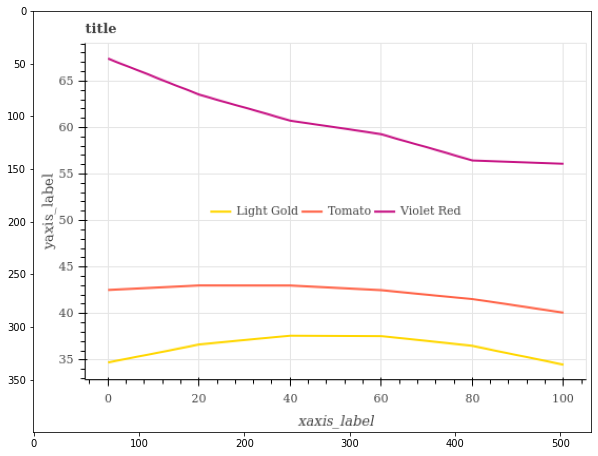

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import random

def subject_model_predict(model, 
               imgs, 
               description_type,
               opposite_subject_onehot, 
               subject_lengths):
  
  # note we are providing them cross. So first element model gets second question type 
  subject_prediction_scores = model(imgs, 
                                    description_type, 
                                    opposite_subject_onehot.float(), 
                                    subject_lengths=subject_lengths)
  
  return subject_prediction_scores
  


def category_model_predict(model, imgs):
  category_prediction_scores = model(imgs)
  return category_prediction_scores


def category_prediction_scores_to_categories(scores, pick_most_confident=True):
  scores = scores.cpu().numpy()
  pred_threshold = 1/scores.shape[1]

  if (pick_most_confident):
    predicted_category_indices = [np.argmax(scores)]
  else:
    predicted_category_indices =  [i for i in np.where(scores > pred_threshold)[1]]
  categories_as_strings = [question_types[category_idx] for category_idx in predicted_category_indices]

  return predicted_category_indices, categories_as_strings


def generate_description(description_type, first_subject, second_subject):
  if (description_type == 'GREATER'):
    return f"{first_subject} is greater than {second_subject}"
  if (description_type == 'LESS'):
    return f"{first_subject} is less than {second_subject}"
  if (description_type == 'INTERSECT'):
    return f"{first_subject} intersects {second_subject}"



def subjects_model_predictions_to_subjects(first_subject_prediction_scores, 
                                           second_subject_prediction_scores, subjects, k=3):
  
  # clamp predictions
  first_subject_prediction_scores[:, len(subjects):] = 0
  second_subject_prediction_scores[:, len(subjects):] = 0


  _, top_first_subject_indexes = torch.topk(first_subject_prediction_scores, k)
  top_first_subject_indexes = top_first_subject_indexes.cpu().numpy().tolist()[0]

  _, top_second_subject_indexes = torch.topk(second_subject_prediction_scores, k)
  top_second_subject_indexes = top_second_subject_indexes.cpu().numpy().tolist()[0]

  zipped = list(zip(top_first_subject_indexes, top_second_subject_indexes))

  subjects_converted = []

  for index_pair in zipped:
    subjects_converted.append([subjects[index_pair[0]], subjects[index_pair[1]]])

  return subjects_converted


def infer(batch):
  imgs = batch['image'].to(device)
  description_type = batch['first_description_type'].to(device)
  subject_lengths = batch['subject_lengths'].to(device)

  imgs = encoder(imgs)

  category_prediction_scores = category_model_predict(category_model, imgs)
  predicted_category_indices, predicted_category_strings = category_prediction_scores_to_categories(category_prediction_scores, 
                                                                                                    pick_most_confident=False)

  subjects = json.loads(batch['all_subjects_blob'][0])

  print("Most confident category prediction: ", predicted_category_strings)
  plt.figure(figsize = (10, 10))
  plt.imshow(batch['original_image'][0])

  for idx, category_index in enumerate(predicted_category_indices):
    predicted_category_onehot = [0]*(len(question_types))
    predicted_category_onehot[category_index] = 1
    predicted_category_onehot = torch.tensor(predicted_category_onehot).float().to(device)

    predicted_category_onehot = predicted_category_onehot.unsqueeze(0)

    first_subject_opposite_onehot = torch.zeros(max_subjects_len).unsqueeze(0).to(device)
    first_subject_prediction_scores = subject_model_predict(first_subject_model,
                       imgs,
                       description_type,
                       opposite_subject_onehot=first_subject_opposite_onehot,
                       subject_lengths=subject_lengths
                       )
    

    second_subject_opposite_onehot = torch.zeros(max_subjects_len)
    predicted_first_subject_index = torch.argmax(first_subject_prediction_scores).clone().cpu().numpy()
    second_subject_opposite_onehot[predicted_first_subject_index] = 1
    second_subject_opposite_onehot = second_subject_opposite_onehot.unsqueeze(0).to(device)

    second_subject_prediction_scores = subject_model_predict(second_subject_model,
                       imgs,
                       description_type,
                       opposite_subject_onehot=second_subject_opposite_onehot,
                       subject_lengths=subject_lengths
                       )
    
    top_k_subject_pairs = subjects_model_predictions_to_subjects(first_subject_prediction_scores,
                                                                                  second_subject_prediction_scores,
                                                                                  subjects, k=3)
    
    for top_idx, subject_pair in enumerate(top_k_subject_pairs):
      category = predicted_category_strings[idx]
      print(f"Model top-{top_idx+1} prediction for {category}: {generate_description(category, subject_pair[0], subject_pair[1])}")

infer_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

batch = next(iter(infer_loader))


with torch.no_grad():
  infer(batch)

In [ ]:
raise ValueError("Nope")

def descriptions_equal(a, b):
  return a[0] == b[0] and a[1] == b[1] and a[2] == b[2]


def predicted_description_present(predicted, targets):
  for target in targets:
    if (descriptions_equal(predicted, target)):
      return True

  return False

def validate(batch):
  global total_count
  global predicted_present_count

  imgs = batch['image'].to(device)
  description_type = batch['first_description_type'].to(device)
  subject_lengths = batch['subject_lengths'].to(device)

  imgs = encoder(imgs)

  category_prediction_scores = category_model_predict(category_model, imgs)
  predicted_category_indices, predicted_category_strings = category_prediction_scores_to_categories(category_prediction_scores, 
                                                                                                    pick_most_confident=False)

  subjects = json.loads(batch['all_subjects_blob'][0])
  descriptions = json.loads(batch['description_blob'][0])

  predicted_descriptions = []

  for idx, category_index in enumerate(predicted_category_indices):
    predicted_category_onehot = [0]*(len(question_types))
    predicted_category_onehot[category_index] = 1
    predicted_category_onehot = torch.tensor(predicted_category_onehot).float().to(device)

    predicted_category_onehot = predicted_category_onehot.unsqueeze(0)

    first_subject_opposite_onehot = torch.zeros(max_subjects_len).unsqueeze(0).to(device)
    first_subject_prediction_scores = subject_model_predict(first_subject_model,
                       imgs,
                       description_type,
                       opposite_subject_onehot=first_subject_opposite_onehot,
                       subject_lengths=subject_lengths
                       )
    

    second_subject_opposite_onehot = torch.zeros(max_subjects_len)
    predicted_first_subject_index = torch.argmax(first_subject_prediction_scores).clone().cpu().numpy()
    second_subject_opposite_onehot[predicted_first_subject_index] = 1
    second_subject_opposite_onehot = second_subject_opposite_onehot.unsqueeze(0).to(device)

    second_subject_prediction_scores = subject_model_predict(second_subject_model,
                       imgs,
                       description_type,
                       opposite_subject_onehot=second_subject_opposite_onehot,
                       subject_lengths=subject_lengths
                       )
    
    top_k_subject_pairs = subjects_model_predictions_to_subjects(first_subject_prediction_scores,
                                                                                  second_subject_prediction_scores,
                                                                                  subjects)
    category = predicted_category_strings[idx]
    predicted_descriptions.append([category, subjects[0], subjects[1]])

  #print("pred", predicted_descriptions)
  #print("actual", descriptions)

  total_count += 1

  for predicted in predicted_descriptions:
    if (predicted_description_present(predicted, descriptions)):
      predicted_present_count += 1


predicted_present_count = 0
total_count = 0

with torch.no_grad():
  for batch in val_loader:
    try:
      validate(batch)
    except:
      pass

print(predicted_present_count, total_count)